# Intuitions on Convolutions

Let's build intuitions about these **`convolution operations`**.

🎯 <b><u>Goals</u></b>
- **Compute convolution operations**
- **Visualize**
    - convolution kernels
    - the effects of a convolution kernel applied on images

<hr>

🖼 <b><u>Convolutional Neural Networks are Neural Networks specifically designed to work on images</u></b>. 

This is made possible thanks to **convolutions**.

These specific mathematical operations apply a **`kernel`** to an input image and creates an output representation. The name of this **`output`** can change depending on the community. Here, let's talk about the output as the **`output of a layer`**, as in standard NeuralNet models. But for Convolutional Neural Networks, it can also be called :
* a **`"convoluted representation/feature"`**,
* or a **`"convolution"`**,
* or also an **`"activation"`** (as it corresponds to the activation of a given layer).

<img src="convolution.png" width="300">

---

❗️ <b><u>Remarks</u></b> ❗️

* It is important to understand that **the same kernel, i.e. the same weights, are applied to different zones of the images**. 

* This is completely different from Dense Neural Networks that we've been working with during the last two chapters:
    * In `Dense/"Fully Connected" Neural Network`, each weight of each neuron is related to only one input coordinate (which in this case would be each pixel).
    * In a `Convolution Neural Network`, the weights of a kernel are not applied to only one feature input, i.e. one pixel, but to different pixels, "step by step" !

👉 You can think of each kernel (or each filter in the case of colored images) as a **`magnifying glass`** through which you see the image. Similarly to your eyes, kernels cannot capture everything in a picture at once, but they ***scan different parts of a picture before understanding the whole picture which is being analyzed***.

🎬 So let's have a closer look at `convolution operations`, and their impact in `Convolutional Neural Networks`.

## (0) The dataset



❓ First use the following function `load_data` to... to load the data ❓

* Do not change anything in the function !
* Restrict from any desire to change the shapes or types of the outputs! This will have an impact on further questions.

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib.pyplot import imread

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    nb_circles = 100
    nb_triangles = 100
    
    X, y = [], []
    
    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        X.append(imread(c_path)[:, :, :1])
        y.append(0)
    
    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        X.append(imread(t_path)[:, :, :1])
        y.append(1)
        
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
        
    return np.array(X), np.array(y)
        
X, y = load_data("data")
# Replace data by "https://wagon-public-datasets.s3.amazonaws.com/deep-learning-circles-triangles" 
# if you are on a server

❓ **Question about the shape** ❓

* How many images do we have ?
* What are their dimensions ? 
* Can you comment on the number of channels ? 

In [2]:
X.shape

(200, 76, 78, 1)

<details>
    <summary><i>About the number of channels:</i></summary>
   
Actually, we have already talked about this during the `MNIST challenge`.        
        
*  We need only one channel to compute the "*blackness intensity*" of a pixel with 0 corresponding to a black pixel and 1 corresponding to a white pixel. The last dimension corresponds to some kind of  "Black to white channel". 
        
🎨 For colored images, the last dimension would be equal to 3 for `Red, Green, Blue (RGB)`

👉 Have fun playing with the intensities of Red, Green and Blue <a href="https://www.w3schools.com/colors/colors_rgb.asp">`here`</a>
        
        
</details>        

❓ **Question about the normalization** ❓

Do these images need some normalization ? 

In [4]:
X.max()

1.0

In [5]:
X.min()

0.0

❓ **Question** : Display some images with `plt.imshow` and their respective labels ❓

_Note: the images are black and white, therefore use `cmap=gray` in the dedicated matplotlib function - otherwise, you will see unrelevant and weird colors...

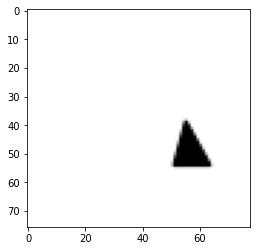

In [6]:
plt.imshow(X[53], cmap='gray')

❓ **Question: How many classes are we going to predict** ❓

_It should already give you some information about how to design  the last layer of your Convolutional Network_

In [10]:
np.unique(y)

array([0, 1])

In [13]:
y

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0])

## (1) Kernels

The following function `compute_convolution` performs a **convolution operation** $ \Leftrightarrow $ i.e. *it applies a kernel to an image*.

❗️ <b><u>Vocabulary warning</u></b> ❗️

1. "convolution" sometimes refers to _one_ operation. It can also refer to the convolution operations repeated/slid on the entire image.


2. For [historical reasons](https://towardsdatascience.com/convolution-vs-correlation-af868b6b4fb5), "_convolution_" in CNN is slightly different from "_convolution" in Signal Preprocessing, but both are very close
    - use [`scipy.ndimage.correlate`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.correlate.html#scipy.ndimage.correlate) for CNN_type convolution
    
    - instead of standard [`scipy.ndimage.convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve) or [`numpy.convolve`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html)



❓ **Question about the `compute_convolution` function** ❓

Run it and try to understand the different steps of this function.

In [14]:
def compute_convolution(img, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(img) # Removes dimensions of size 1
    img_height, img_width = img.shape
    
    array = []

    for x in range(img_height - kernel_height):
        arr = []
        
        for y in range(img_width - kernel_width):
            
            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width], kernel)
            arr.append(a.sum())
            
        array.append(arr)
        
    return array

❓ **How does the `compute_convolution` function work in practice** ❓ 


* Choose any image from the input dataset
* Apply the following kernel to it
* Display both the input image and the output image. 
* Do you see differences ?

In [15]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

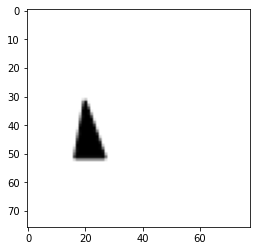

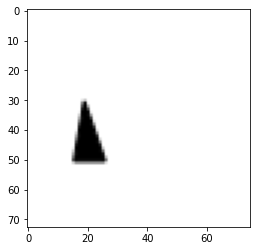

In [16]:
output = compute_convolution(X[0], identity_kernel)

plt.imshow(X[0], cmap='gray')
plt.show()

plt.imshow(output, cmap='gray')
plt.show()

<details>
    <summary><i>Answer</i></summary>
        
🧑🏻‍🏫 The previous kernel corresponds to the **`identity_kernel`**, meaning that **the output is equal to the input**... 
    
🕵🏻‍♂️ It basically did nothing to the input image. It you think about it thoroughly, that's not surprising. With this kernel, only the pixel scanned in the middle is kept and multiplied by one, the rest is multiplied by zero.        
        
</details>        

🎁 We coded a function `plot_convolution` that plots the output image from an input image on which a kernel was applied.

❓ **Question**: `plot_convolution` with the following`kernel_1` ❓

Apply it once on an triangle and once on a circle.

In [17]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''
    
    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)
    
    plt.figure(figsize=(10, 5))
    
    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')
    
    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')    
    
    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')    

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [18]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

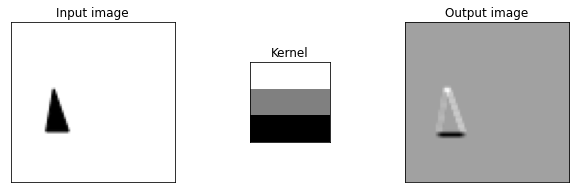

In [19]:
plot_convolution(X[0], kernel_1)

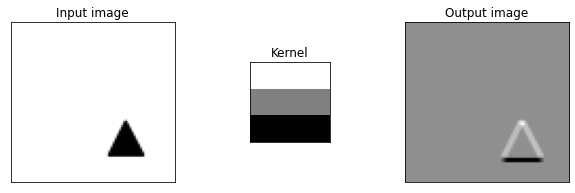

In [20]:
plot_convolution(X[5], kernel_1)

👆 Let's analyse what just happened:

* White pixels correspond to high values and black pixels to low values.
* In a Neural Network, in a Dense Layer or a Convolutional Layer, there is an activation function. 
    * *For example*, when the activation function is `relu`, you already know that it simply correponds to setting the negative values to 0.

---


❓ **What is the impact of the activation function in a Convolutional Layer ? ** ❓

Re-run the previous function `plot_convolution` with `activation` set to `True` (in this case, the activation function _is_ the relu).

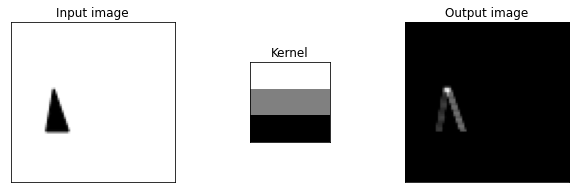

In [21]:
plot_convolution(X[0], kernel_1, activation=True)

👆 This kernel is actually highlighting the edges in a given direction. 

❓ **Play with different kernels...** ❓

Try the following kernels to check the different edges it can detect.

In [22]:
kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],   
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

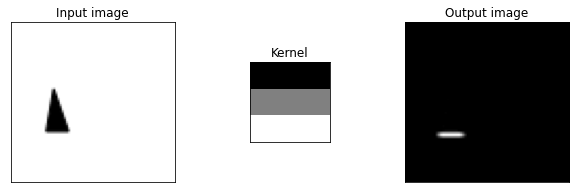

In [23]:
plot_convolution(X[0], kernel_2, activation=True)

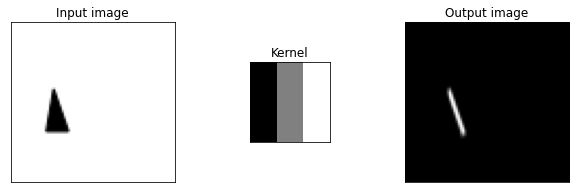

In [24]:
plot_convolution(X[0], kernel_3, activation=True)

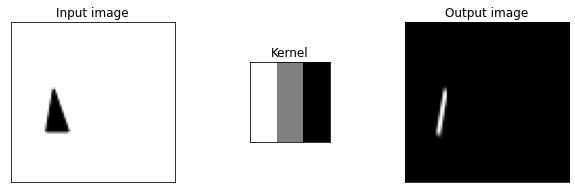

In [25]:
plot_convolution(X[0], kernel_4, activation=True)

❓ **What is the effect of the kernel size** ❓

Try the _kernel_big_.

In [26]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

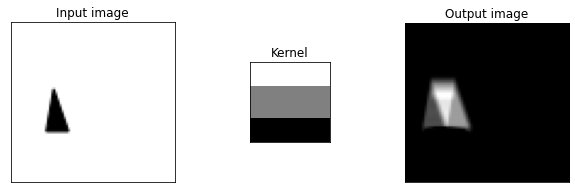

In [27]:
plot_convolution(X[0], kernel_big, activation=True)

❓ **Try another kernel**  ❓

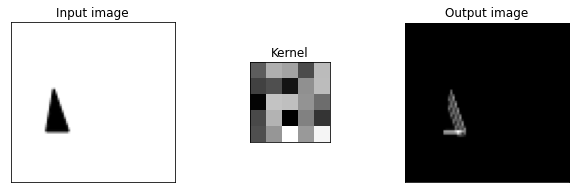

In [28]:
random_kernel = np.random.uniform(-10, 10, (5, 5))
plot_convolution(X[0], random_kernel, activation=True)

Now that you've got the idea of what a convolution operation does to an image, let's see how it goes with a "real" Convolutional Neural Network. ✅

## (2) Convolutional Neural Network

### (2.1) Architecture and training


❓ **Question: Designing a CNN** ❓

Write a Convolutional Network that has 
- a Convolutional Layer with 16 filters with $ (4, 4) $ kernels.
- a Convolutional Layer with 32 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 32 filters with $ (3, 3) $ kernels.
- a Convolutional Layer with 32 filters with $ (2, 2) $ kernels.

with:
- A Max-Pooling Layer (with a $ (2, 2) $ pool-size) after each convolution.
- A Hidden Dense Layer with the size of your choice, be reasonable:
    - after the flattening part 
    - but before the last layer


Also, make sure to compile your model with the adequate parameters

In [29]:
from tensorflow.keras import layers, models

2022-03-02 21:48:40.341897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 21:48:40.341964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [32]:
def initialize_model():
    
    model = models.Sequential()  
    
    model.add(layers.Conv2D(16, (4,4), activation='relu', input_shape=(76,78,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (2,2), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
model = initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 73, 75, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 35, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)        

❓ **Question: Training the CNN** ❓

* Fit the model. You should achieve a accuracy of *at least* 90%. 

    * When you reach such a high score, it may sound suspicious and you would probably ask yourself whether the model is overfitting or not... but let's ignore it for this challenge 😏

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5)

model = initialize_model()

history = model.fit(X, y,
                    validation_split = 0.3,
                    batch_size = 16,
                    epochs=50,
                    callbacks=[es],
                    verbose = 1)

Epoch 1/50
9/9 [==============================] - 1s 74ms/step - loss: 0.6838 - accuracy: 0.5214 - val_loss: 0.6829 - val_accuracy: 0.4500
Epoch 2/50
9/9 [==============================] - 0s 45ms/step - loss: 0.6551 - accuracy: 0.5214 - val_loss: 0.6410 - val_accuracy: 0.4500
Epoch 3/50
9/9 [==============================] - 0s 43ms/step - loss: 0.5937 - accuracy: 0.5571 - val_loss: 0.5832 - val_accuracy: 0.5333
Epoch 4/50
9/9 [==============================] - 0s 44ms/step - loss: 0.5022 - accuracy: 0.6929 - val_loss: 0.5914 - val_accuracy: 0.4500
Epoch 5/50
9/9 [==============================] - 0s 43ms/step - loss: 0.4302 - accuracy: 0.7714 - val_loss: 0.4701 - val_accuracy: 0.9000
Epoch 6/50
9/9 [==============================] - 0s 42ms/step - loss: 0.3182 - accuracy: 0.9429 - val_loss: 0.2597 - val_accuracy: 0.9500
Epoch 7/50
9/9 [==============================] - 0s 49ms/step - loss: 0.1341 - accuracy: 0.9786 - val_loss: 0.2139 - val_accuracy: 0.9333
Epoch 8/50
9/9 [===========

🎁 We coded the `plot_loss_accuracy` for you.

❓ **Question: does the CNN converge** ❓

_Also, do you see any sign of overfitting ?_

In [35]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

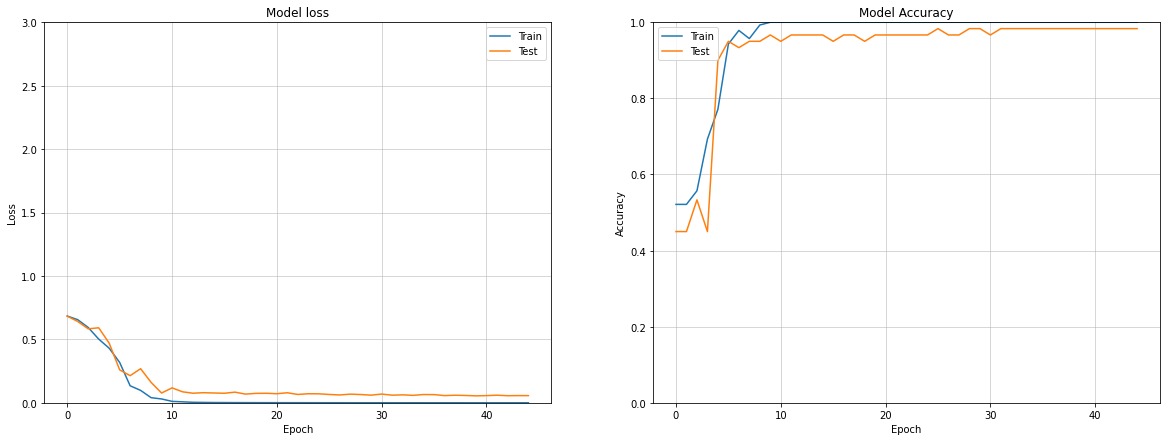

In [36]:
plot_loss_accuracy(history)

### (2.2) Deeper understanding of the CN

🕵️‍♀️ With the following table, you will have a better overview of the different weights, kernels and filters involved in the CNN you've built earlier:

| layer_number | convolution_layer | kernel_number | channel_number |
|--------------|-------------------|---------------|----------------|
| 0            | conv2D no 1       | 16            | 1              |
| 2            | conv2D no 2       | 32            | 16             |
| 4            | conv2D no 3       | 64            | 32             |
| 8            | conv2D no 4       | 64            | 64             |

#### (2.2.1) Kernels

🔥 It is possible to **retrieve the values of all the kernels after training a CNN**. 

👩🏻‍🏫 For any Sequential Neural Network (Dense or Convolutional), you can:
- print the **`.summary()`** to display the layers and the number of weights/parameters involved
- access the differents **`.layers`** of your model
- access the differents parameters **`.weights`** of this layer

❓ **List the different layers of your CNN model** ❓

In [37]:
model.layers

❓ **Try to access the weights matrix `w` of your first convolution layer, then your second one** ❓  
hint: layer parameters consist of weight matrix and biases (w, b)

In [45]:
model.layers[0].weights

[<tf.Variable 'conv2d_8/kernel:0' shape=(4, 4, 1, 16) dtype=float32, numpy=
 array([[[[-6.45842180e-02, -1.02854613e-02, -6.72683045e-02,
            3.33892666e-02, -1.32165566e-01,  5.46769463e-02,
            1.87239915e-01, -1.36393514e-02, -1.20833591e-01,
            1.05669670e-01, -1.21751486e-03,  7.74219111e-02,
            1.47527633e-02,  1.11854248e-01, -8.47080275e-02,
            1.31695002e-01]],
 
         [[-9.50237066e-02,  5.66925816e-02, -8.02799910e-02,
            5.06040566e-02,  6.02095127e-02, -7.99786597e-02,
            1.03044197e-01,  7.60089532e-02, -7.82167986e-02,
            4.81653437e-02,  7.13100061e-02,  1.83414161e-01,
           -1.31953180e-01,  1.49927944e-01,  4.34038490e-02,
            1.07112207e-01]],
 
         [[-1.27788529e-01,  1.07458964e-01, -6.54450208e-02,
            9.26012844e-02, -3.30145508e-02, -1.49396896e-01,
           -2.37745941e-02, -1.31879151e-01,  7.30589181e-02,
            1.90229237e-01,  1.50061384e-01,  1.603879

In [40]:
model.layers[0].weights[0].shape

TensorShape([4, 4, 1, 16])

❓ **What do their shapes represent** ❓

👉 `[4, 4, 1, 16]` represent 
- the weights of filters of size `4` * `4`
- that we apply to the channel number `1`(single B&W input)
- and we have decided to apply `16` different kernels in this layer!

<details>
    <summary><i>More parameters...</i></summary>

<b><u>Parameters of the convolutional layers</u></b>  
    
```python
# First Conv2D Layer --> 16 kernels - 4x4 
model.layers[0].weights[0].numpy()[:,:,0].shape    
```
$(4,4,16)$    
    
```python
# Second Conv2D Layer --> 32 kernels - 3x3 
model.layers[2].weights[0].numpy()[:,:,0].shape    
```
$ (3,3,32) $
    
```python    
# Third Conv2D Layer --> 64 kernels - 3x3 
model.layers[4].weights[0].numpy()[:,:,0].shape
```    
$ (3, 3, 64) $
    
```python
# Fourth/Last Conv2D Layer --> 64 kernels - 2x2
model.layers[6].weights[0].numpy()[:,:,0].shape
```
    
$ (2, 2, 64) $    
    
<b><u>Parameters of the dense layers</u></b>   
    
```python
model.layers[-2].weights[0].shape
model.layers[-2].weights[1].shape    
```
$ (576, 10) $    
$ (10,) $        
    
```python
model.layers[-1].weights[0].shape
model.layers[-1].weights[1].shape    
```
$ (10, 1) $    
$ (1,) $       
</details>

❓ **Question: visualizing the first layer** ❓ 

The original picture had 1 channel.. and we created 16 outputs using 16 kernels !

🪄 Using `plot_convolution(activation = True)`, display some kernels from the first convolutional layer, along with the activation output, to see what the model has learned from the images in this layer.

In [54]:
kernel0 = model.layers[0].weights[0].numpy()[:,:,0,15]

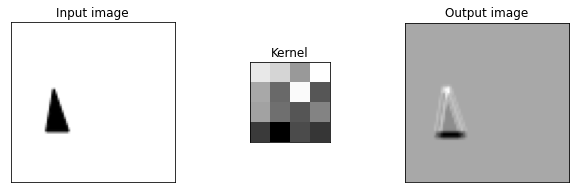

In [55]:
plot_convolution(X[0], kernel0)

------------------------- Effect of the kernel number 0 -------------------------


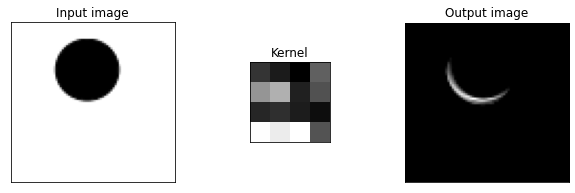

------------------------- Effect of the kernel number 1 -------------------------


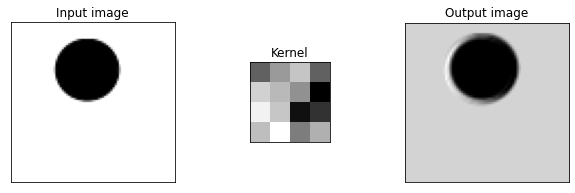

------------------------- Effect of the kernel number 2 -------------------------


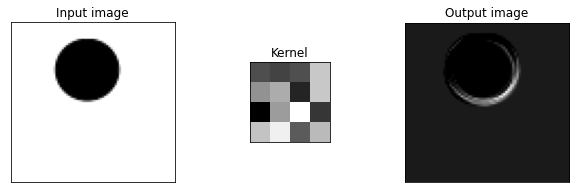

------------------------- Effect of the kernel number 3 -------------------------


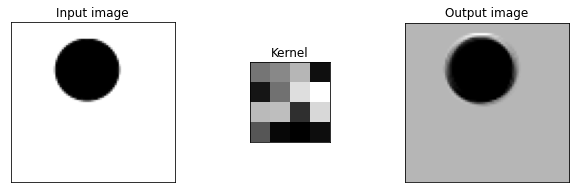

------------------------- Effect of the kernel number 4 -------------------------


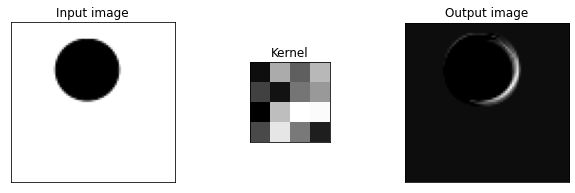

------------------------- Effect of the kernel number 5 -------------------------


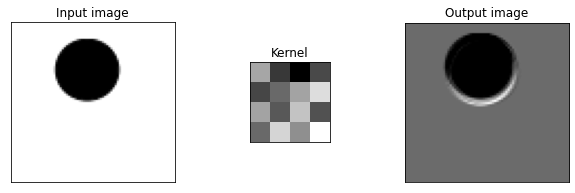

------------------------- Effect of the kernel number 6 -------------------------


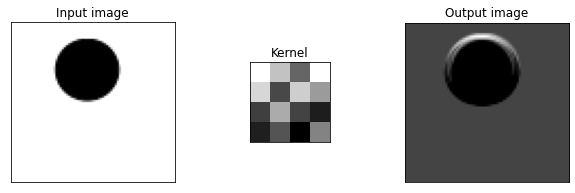

------------------------- Effect of the kernel number 7 -------------------------


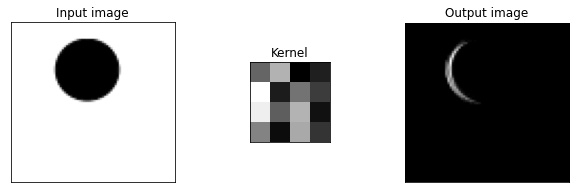

------------------------- Effect of the kernel number 8 -------------------------


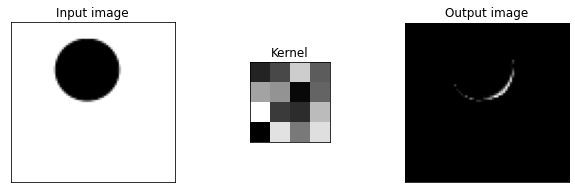

------------------------- Effect of the kernel number 9 -------------------------


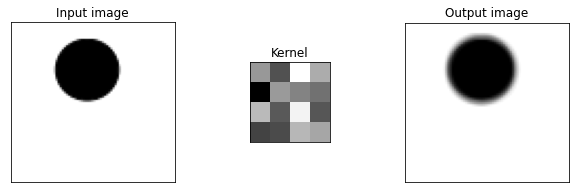

------------------------- Effect of the kernel number 10 -------------------------


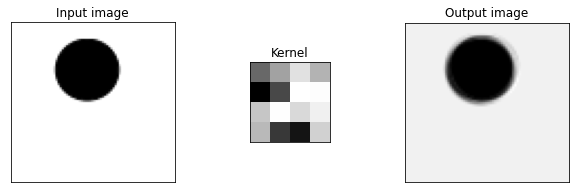

------------------------- Effect of the kernel number 11 -------------------------


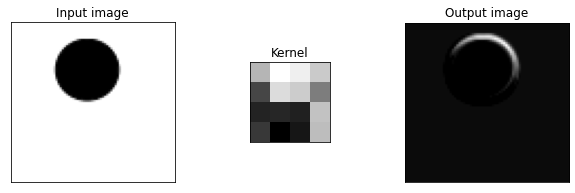

------------------------- Effect of the kernel number 12 -------------------------


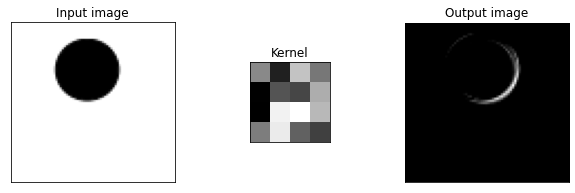

------------------------- Effect of the kernel number 13 -------------------------


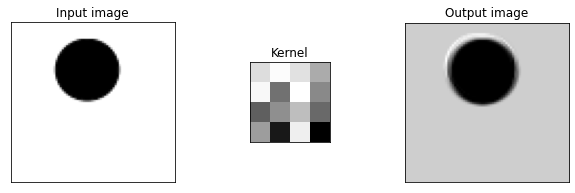

------------------------- Effect of the kernel number 14 -------------------------


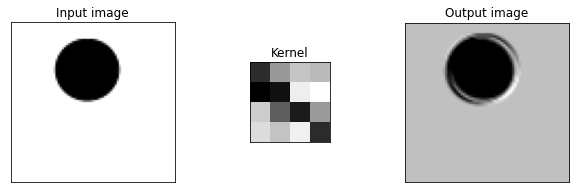

------------------------- Effect of the kernel number 15 -------------------------


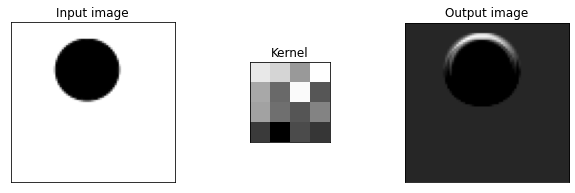

In [42]:
layer_number = 0
channel_number = 0
for k in np.arange(0, 16):
    print(f"------------------------- Effect of the kernel number {k} -------------------------")
    kernel = model.layers[layer_number].weights[0].numpy()[:, :, channel_number, k]
    plot_convolution(X[1], kernel, activation=True)

#### (2.2.2) Activations

We have been looking at the activation ("`output image`") of the **first convolutional layer** only.

🤔 What if we want to **visualize the activation of an image after the second convolutional layer of the CNN, or the third one?**

1. We'll need to compute activation from the first layer
2. Then feed it to the second to compute activation of the second one
3. Then feed it to the third ...
4. etc...

👇 We'll do it for you below using the  `tensorflow.keras` `Fonctional API` syntax! Make sure you understand it all !

<u><i>Step 1 : list all the 11 layers' outputs of your CNN</i></u>

In [56]:
layers_outputs = [layer.output for layer in model.layers]
layers_outputs

[<KerasTensor: shape=(None, 73, 75, 16) dtype=float32 (created by layer 'conv2d_8')>,
 <KerasTensor: shape=(None, 36, 37, 16) dtype=float32 (created by layer 'max_pooling2d_8')>,
 <KerasTensor: shape=(None, 34, 35, 32) dtype=float32 (created by layer 'conv2d_9')>,
 <KerasTensor: shape=(None, 17, 17, 32) dtype=float32 (created by layer 'max_pooling2d_9')>,
 <KerasTensor: shape=(None, 15, 15, 32) dtype=float32 (created by layer 'conv2d_10')>,
 <KerasTensor: shape=(None, 7, 7, 32) dtype=float32 (created by layer 'max_pooling2d_10')>,
 <KerasTensor: shape=(None, 6, 6, 32) dtype=float32 (created by layer 'conv2d_11')>,
 <KerasTensor: shape=(None, 3, 3, 32) dtype=float32 (created by layer 'max_pooling2d_11')>,
 <KerasTensor: shape=(None, 288) dtype=float32 (created by layer 'flatten_2')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>]

<u><i>Step 2: Instantiate 11 sub-models re-using already trained weights and biases</i></u> 
- layer1
- layer1-->layer2
- layer1-->layer2-->layer3
- ... 

In [62]:
activation_models = [Model(inputs=model.input, outputs=output) for output in layers_outputs]

NameError: name 'Model' is not defined

<u><i>Step 3: Compute the outputs of each submodel</i></u>

In [ ]:
activations = [m.predict(X) for m in activation_models]
len(activations)

👇 Pro tips below! In tensorflow, you could also create a single model with many outputs to avoid python loops 

In [ ]:
layers_outputs = [layer.output for layer in model.layers] # same than above
activation_model = Model(inputs=model.input, outputs=layers_outputs) # model with many outputs !
activations = activation_model.predict(X) # 11 prediction at once!

❓ **Now that we computed activations, choose one image and display the activation "images" of each convolutional layer** ❓ 


In [ ]:
# YOUR CODE HERE

🧑🏻‍🏫 ***Notes*** 🧑🏻‍🏫

1. Notice how the information of an image **flows** through the Convolutional Neural Network.
2. You should see the picture becoming more and more "abstract", of smaller and smaller "dimensions"

🏁 **Congratulations!**

💾 Don't forget to `git add/commit/push` your notebook...

🚀 ... and move on to the next challenge !

## (3) (Appendix) Utils

* The following section simply presents the functions that helped us create the dataset with triangles and circles you have been working with.

* They were left at the end of the notebook just in case you want to further prototype and get better understanding of what is going on. 

* But skip this section and go to the next exercise as for now, and come back to it any time later.

In [ ]:
def draw_triangle():
    dx = np.random.uniform(0.1, 0.3)
    dy = np.random.uniform(0.1, 0.3)
    noise_x = np.random.uniform(0.0, 0.1)
    noise_y = np.random.uniform(0.0, 0.1)    
    
    x = np.random.uniform(0, 1-dx-noise_x)
    y = np.random.uniform(0, 1-dy)
    X = np.array([[x,y], [x+dx+noise_x,y], [x+dx/2, y+dy+noise_y]])

    t1 = plt.Polygon(X, color='black')
    plt.gca().add_patch(t1)
    
def draw_circle():
    r = np.random.uniform(0.1, 0.25)
    x = np.random.uniform(0+r, 1-r)
    y = np.random.uniform(0+r, 1-r)

    circle1 = plt.Circle((x, y), r, color='black')
    plt.gcf().gca().add_artist(circle1)
    
def create_image(form, path):
    plt.figure(figsize=(1, 1))
    if form == 'circle':
        draw_circle()
    elif form == 'triangle':
        draw_triangle()
    plt.axis('off')
    plt.savefig(path, dpi=80, bbox_inches='tight')
    plt.close()

    
def create_images(path):
    nb_circles = 100
    nb_triangles = 100
    
    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        create_image('circle', c_path)
        
    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        create_image('triangle', t_path)